# How to download flights csv file from transtats website

**In this notebook, we will**
1. Download a csv file for each of your chosen year(s) and month(s)
2. Prepare the data for further processing
3. Push the prepared data to a table in the database




In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import psycopg2 # needed to get database exception errors when uploading dataframe
import requests # package for getting data from the web
from zipfile import * # package for unzipping zip files

In [2]:
# Import the get_engine function from our sql_functions.
from sql_functions import get_engine #adjust this as necessary to match your sql_functions.py connection methods

# 1. Download csv file with flight data for your specific year/month

In the following, you are going to download a csv file containing flight data from [this website](https://transtats.bts.gov).    
You can specify, which data you want to download. 

Choose a month/year that you want to explore further.
With the following functions, you will download a csv file on public flight data from [this website](https://transtats.bts.gov) containing data of your chosen month/year.    
The file will be stored in a data folder.
Check out the url from which we download the data(https://transtats.bts.gov/PREZIP). Can we download data in this way from every source? What do you think?

In [3]:
# Specifies path for saving file
path ='data/' 
# Create the data folder
!mkdir {path}

mkdir: data/: File exists


In [4]:
# function to get specified csv file from the website https://transtats.bts.gov

def download_data(year, month):
    # Get the file from the website https://transtats.bts.gov
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
    # Download the database
    r = requests.get(f'{url}', verify=False)
    # Save database to local file storage
    with open(path+zip_file, 'wb') as f:
        f.write(r.content)
        print(f'--> zip_file with name: {zip_file} downloaded succesfully.' )
    

In [5]:
# function to extract the csv files inside the zip files

def extract_zip(year, month):
    # Get the file from the website https://transtats.bts.gov
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    with ZipFile(path+zip_file, 'r') as zip_ref:
        zip_ref.extractall(path)
        csv_file =  zip_ref.namelist()[0]
        print(f'--> zip_file was succesfully extracted to: {csv_file}.' )

Don't worry - the following download of the data you chose may take some time ...

In [6]:
years_list = [2010] # list of years you want to look at (can of course also be a single year)
months_list = [2] # list of months you want to look at (can of course also be a single month)

# download flights data as zipfile(s)
# we use a nested loop to specify the years and months to define the range of the data we would like to have 
for year in years_list:
    for month in months_list:
        download_data(year, month)
        extract_zip(year, month)

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


--> zip_file with name: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2010_2.zip downloaded succesfully.
--> zip_file was succesfully extracted to: On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2010_2.csv.


Now it is time to load the csv files into dataframes. You can create your own function equivalent to the functions above. But you need to decide whether...

- Do you need one dataframe for every month?
- Would you like to proceed with only one dataframe containing all the data you downloaded?
- One dataframe for every year?

There are certain things to consider before.
- changing column names
- dealing with missing data
- changing datatypes

In [7]:
# define the name of the csv file you want to read in
csv_file = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2010_2.csv'

# Read in your data
df = pd.read_csv(path+csv_file, low_memory = False)
display(df.shape)
display(df.head())

(483270, 110)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2010,1,2,2,2,2010-02-02,WN,19393,WN,N907WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,1,2,2,2,2010-02-02,WN,19393,WN,N270WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,1,2,2,2,2010-02-02,WN,19393,WN,N357SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,1,2,2,2,2010-02-02,WN,19393,WN,N918WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,1,2,2,2,2010-02-02,WN,19393,WN,N355SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Prepare the csv file for further processing

In the next step, we clean and prepare our dataset.

a) Since the dataset consists of a lot of columns, we we define which ones to keep.  
(Same as known from our SQL exercises on flights data.)

In [8]:
# Columns from downloaded file that are to be kept

columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'ActualElapsedTime',
                'Distance',
                'Cancelled',
                'Diverted'
]

In [9]:
# The columns in the database have different naming as in the source csv files. Lets get the names from the database

schema = 'hh_analytics_24_1' # UPDATE 'TABLE_SCHEMA' based on schema used in class 
engine = get_engine() # assign engine to be able to query against the database

table_name_sql = f'''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='{schema}'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('actual_elapsed_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [10]:
# we can clean up the results into a clean list
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names        

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'actual_elapsed_time',
 'distance',
 'cancelled',
 'diverted']

In [11]:
# Just in case the above fails here are the results
'''new_column_names_alternate = ['flight_date', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', 
                'arr_delay', 'airline', 'tail_number', 'flight_number', 'origin', 'dest', 'air_time', 'actual_elapsed_time', 'distance', 'cancelled', 'diverted' ]'''

"new_column_names_alternate = ['flight_date', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', \n                'arr_delay', 'airline', 'tail_number', 'flight_number', 'origin', 'dest', 'air_time', 'actual_elapsed_time', 'distance', 'cancelled', 'diverted' ]"

b) With the next function, we make our csv file ready to be uploaded to SQL.  
We only keep to above specified columns and convert the datatypes.

In [12]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    df_airline['ActualElapsedTime']= pd.to_numeric(df_airline['ActualElapsedTime'], downcast='integer', errors='coerce')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [13]:
# Call function and check resulting dataframe
df_clean = clean_airline_df(df)
df_clean.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
0,2010-02-02,830.0,830,0.0,842.0,900,-18.0,WN,N907WN,334,CLE,MDW,60.0,72.0,307.0,0,0
1,2010-02-02,1129.0,1135,-6.0,1134.0,1200,-26.0,WN,N270WN,356,CLE,MDW,55.0,65.0,307.0,0,0
2,2010-02-02,1424.0,1420,4.0,1443.0,1440,3.0,WN,N357SW,967,CLE,MDW,54.0,79.0,307.0,0,0
3,2010-02-02,625.0,635,-10.0,639.0,705,-26.0,WN,N918WN,1945,CLE,MDW,61.0,74.0,307.0,0,0
4,2010-02-02,1930.0,1820,70.0,1933.0,1845,48.0,WN,N355SW,2624,CLE,MDW,51.0,63.0,307.0,0,0


If you decide to only look at specific airports, it is a good decision to filter for them in advance.  
This function does the filtering. 

In [14]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport(df, airports):
    ''' Helper function for filtering the airline dataframe for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out


In [15]:
# Execute function, filtering for New York area airports
airports=['DCA', 'IAD', 'BWI', 'PHL', 'EWR', 'JFK', 'LGA']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
8,2010-02-02,1825.0,1830,-5.0,1926.0,1945,-19.0,WN,N257WN,484,CMH,BWI,50.0,61.0,336.0,0,0
9,2010-02-02,1047.0,1025,22.0,1153.0,1135,18.0,WN,N308SA,801,CMH,BWI,52.0,66.0,336.0,0,0
10,2010-02-02,1331.0,1335,-4.0,1434.0,1445,-11.0,WN,N751SW,1480,CMH,BWI,52.0,63.0,336.0,0,0
11,2010-02-02,638.0,630,8.0,749.0,740,9.0,WN,N942WN,3137,CMH,BWI,50.0,71.0,336.0,0,0
176,2010-02-02,949.0,955,-6.0,1453.0,1515,-22.0,WN,N799SW,146,DEN,BWI,173.0,184.0,1491.0,0,0


# 3. Push the prepared data to a table in the database

In [16]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
# Example: flights_sp for Sina's flights table, flights_groupname or similar
table_name = 'flights_table_api'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This may take some time ...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        df_selected_airports.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The flights_table_api table was imported successfully.


In [17]:
from sql_functions import get_dataframe

In [19]:
schema = 'hh_analytics_24_1'

sql_query = f'SELECT * FROM {schema}.flights_table_api'
flights = get_dataframe(sql_query)

flights.head(20)

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
0,2010-02-02,1825.0,1830,-5.0,1926.0,1945,-19.0,WN,N257WN,484,CMH,BWI,50.0,61.0,336.0,0,0
1,2010-02-02,1047.0,1025,22.0,1153.0,1135,18.0,WN,N308SA,801,CMH,BWI,52.0,66.0,336.0,0,0
2,2010-02-02,1331.0,1335,-4.0,1434.0,1445,-11.0,WN,N751SW,1480,CMH,BWI,52.0,63.0,336.0,0,0
3,2010-02-02,638.0,630,8.0,749.0,740,9.0,WN,N942WN,3137,CMH,BWI,50.0,71.0,336.0,0,0
4,2010-02-02,949.0,955,-6.0,1453.0,1515,-22.0,WN,N799SW,146,DEN,BWI,173.0,184.0,1491.0,0,0
5,2010-02-02,1802.0,1805,-3.0,2320.0,2320,0.0,WN,N401WN,204,DEN,BWI,175.0,198.0,1491.0,0,0
6,2010-02-02,1339.0,1345,-6.0,1841.0,1900,-19.0,WN,N743SW,242,DEN,BWI,170.0,182.0,1491.0,0,0
7,2010-02-02,908.0,910,-2.0,1424.0,1455,-31.0,WN,N927WN,1305,DEN,PHL,183.0,196.0,1557.0,0,0
8,2010-02-02,1800.0,1805,-5.0,2318.0,2335,-17.0,WN,N225WN,2539,DEN,PHL,181.0,198.0,1557.0,0,0
9,2010-02-02,1248.0,1245,3.0,1813.0,1830,-17.0,WN,N792SW,3397,DEN,PHL,172.0,205.0,1557.0,0,0


In [20]:
flights[['cancelled', 'diverted', 'flight_date']].groupby('flight_date').sum()


,cancelled,diverted
flight_date,,
2010-02-01,39,2
2010-02-02,81,2
2010-02-03,85,7
2010-02-04,18,7
2010-02-05,1039,15
2010-02-06,1539,9
2010-02-07,1309,5
2010-02-08,501,7
2010-02-09,1086,8


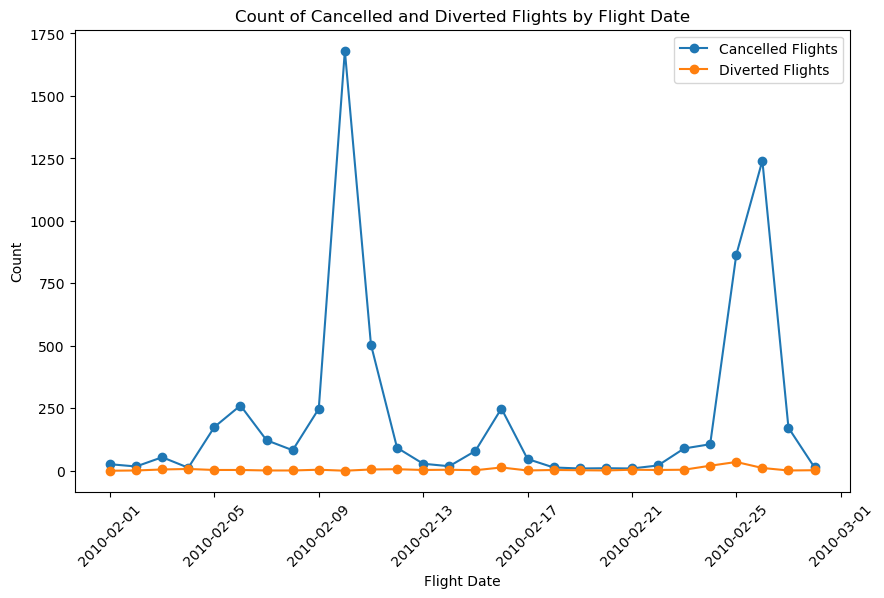

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing flight_date, cancelled, and diverted columns

# Convert flight_date to datetime if it's not already in datetime format
flights['flight_date'] = pd.to_datetime(flights['flight_date'])

# Group by flight_date and aggregate counts of cancelled and diverted flights
agg_flights = flights.groupby('flight_date').agg({'cancelled': 'sum', 'diverted': 'sum'}).reset_index()

# Plot the counts
plt.figure(figsize=(10, 6))
plt.plot(agg_flights['flight_date'], agg_flights['cancelled'], label='Cancelled Flights', marker='o')
plt.plot(agg_flights['flight_date'], agg_flights['diverted'], label='Diverted Flights', marker='o')

# Add labels and title
plt.xlabel('Flight Date')
plt.ylabel('Count')
plt.title('Count of Cancelled and Diverted Flights by Flight Date')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show plot
plt.show()

In [ ]:
# Just to be sure: Check if the number of rows match
table_name_sql = f'SELECT count(*) 
                    FROM {schema}.{table_name}
                    '
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

AB HIER NEU

In [2]:
from sql_functions import get_dataframe

In [3]:
schema = 'hh_analytics_24_1'

sql_query = f'SELECT * FROM {schema}.weather_stacked_groupx'
weather_stacked = get_dataframe(sql_query)

weather_stacked.head(20)

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_id,faa
0,2010-02-01,-0.9,-3.9,2.8,0.0,0.0,270.0,22.3,None,1023.4,None,74486,JFK
1,2010-02-02,-1.0,-3.9,0.6,0.0,0.0,NaN,10.1,None,1023.8,None,74486,JFK
2,2010-02-03,0.3,-2.2,4.4,0.8,25.0,NaN,15.8,None,1018.1,None,74486,JFK
3,2010-02-04,0.8,-1.7,3.3,0.0,0.0,317.0,22.3,None,1025.8,None,74486,JFK
4,2010-02-05,0.6,-1.7,2.8,0.0,0.0,NaN,11.5,None,1023.3,None,74486,JFK
5,2010-02-06,-3.1,-6.1,0.6,2.8,0.0,36.0,33.1,None,1008.1,None,74486,JFK
6,2010-02-07,-4.2,-8.9,1.7,0.0,25.0,330.0,28.1,None,1011.3,None,74486,JFK
7,2010-02-08,-1.2,-5.0,3.9,0.0,0.0,305.0,27.7,None,1014.3,None,74486,JFK
8,2010-02-09,0.8,-2.2,4.4,0.5,0.0,263.0,15.1,None,1015.9,None,74486,JFK
9,2010-02-10,-0.2,-1.1,0.6,31.5,51.0,NaN,31.3,None,992.7,None,74486,JFK


In [14]:
weather_stacked.info

<bound method DataFrame.info of           date  tavg  tmin  tmax  prcp   snow   wdir  wspd  wpgt    pres  \
0   2010-02-01  -0.9  -3.9   2.8   0.0    0.0  270.0  22.3  None  1023.4   
1   2010-02-02  -1.0  -3.9   0.6   0.0    0.0    NaN  10.1  None  1023.8   
2   2010-02-03   0.3  -2.2   4.4   0.8   25.0    NaN  15.8  None  1018.1   
3   2010-02-04   0.8  -1.7   3.3   0.0    0.0  317.0  22.3  None  1025.8   
4   2010-02-05   0.6  -1.7   2.8   0.0    0.0    NaN  11.5  None  1023.3   
5   2010-02-06  -3.1  -6.1   0.6   2.8    0.0   36.0  33.1  None  1008.1   
6   2010-02-07  -4.2  -8.9   1.7   0.0   25.0  330.0  28.1  None  1011.3   
7   2010-02-08  -1.2  -5.0   3.9   0.0    0.0  305.0  27.7  None  1014.3   
8   2010-02-09   0.8  -2.2   4.4   0.5    0.0  263.0  15.1  None  1015.9   
9   2010-02-10  -0.2  -1.1   0.6  31.5   51.0    NaN  31.3  None   992.7   
10  2010-02-11   0.2  -2.2   2.8   0.0  254.0  321.0  32.0  None  1000.6   
11  2010-02-12  -0.9  -3.9   2.2   0.0  229.0  314.0  22

In [4]:
schema = 'hh_analytics_24_1'

sql_query = f'SELECT * FROM {schema}.flights_group_x'
flights_x = get_dataframe(sql_query)

In [5]:
import pandas as pd


merged_df = weather_stacked.merge(flights_x, how='left', left_on='faa', right_on='origin')

# Display the merged DataFrame
print(merged_df)

              date  tavg  tmin  tmax  prcp   snow   wdir  wspd  wpgt    pres  \
0       2010-02-01  -0.9  -3.9   2.8   0.0    0.0  270.0  22.3  None  1023.4   
1       2010-02-01  -0.9  -3.9   2.8   0.0    0.0  270.0  22.3  None  1023.4   
2       2010-02-01  -0.9  -3.9   2.8   0.0    0.0  270.0  22.3  None  1023.4   
3       2010-02-01  -0.9  -3.9   2.8   0.0    0.0  270.0  22.3  None  1023.4   
4       2010-02-01  -0.9  -3.9   2.8   0.0    0.0  270.0  22.3  None  1023.4   
...            ...   ...   ...   ...   ...    ...    ...   ...   ...     ...   
146710  2010-02-15  -1.3  -6.1   2.8   2.3  254.0    NaN  11.9  None     NaN   
146711  2010-02-15  -1.3  -6.1   2.8   2.3  254.0    NaN  11.9  None     NaN   
146712  2010-02-15  -1.3  -6.1   2.8   2.3  254.0    NaN  11.9  None     NaN   
146713  2010-02-15  -1.3  -6.1   2.8   2.3  254.0    NaN  11.9  None     NaN   
146714  2010-02-15  -1.3  -6.1   2.8   2.3  254.0    NaN  11.9  None     NaN   

        ... air_time actual_elapsed_tim

In [17]:
merged_df.columns

Index(['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'tsun', 'station_id', 'faa', 'flight_date', 'dep_time',
       'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time',
       'arr_delay', 'airline', 'tail_number', 'flight_number', 'origin',
       'dest', 'air_time', 'actual_elapsed_time', 'distance', 'cancelled',
       'diverted', 'lat', 'lon', 'city', 'tz_origin', 'tz_dest'],
      dtype='object')

In [6]:
import pandas as pd

# Assuming 'flights' is your DataFrame containing flight data

# Calculate cancellation rate per day
cancellation_rate_per_day = merged_df.groupby('flight_date')['cancelled'].mean()
print(cancellation_rate_per_day)

# Calculate the average cancellation rate per day
average_cancellation_rate_per_day = cancellation_rate_per_day.mean()

##print("Average cancellation rate per day:", average_cancellation_rate_per_day)

flight_date
2010-02-01    0.000000
2010-02-02    0.015244
2010-02-03    0.000000
2010-02-04    0.000000
2010-02-05    0.110482
2010-02-06    0.313916
2010-02-07    0.127907
2010-02-08    0.043228
2010-02-09    0.134146
2010-02-10    0.908824
2010-02-11    0.256831
2010-02-12    0.016393
2010-02-13    0.009174
2010-02-14    0.002841
2010-02-15    0.011111
2010-02-16    0.106443
2010-02-17    0.016713
2010-02-18    0.000000
2010-02-19    0.002732
2010-02-20    0.009119
2010-02-21    0.000000
2010-02-22    0.013812
2010-02-23    0.022409
2010-02-24    0.016807
2010-02-25    0.275956
2010-02-26    0.568306
2010-02-27    0.090634
2010-02-28    0.000000
Name: cancelled, dtype: float64


In [7]:
import matplotlib.pyplot as plt

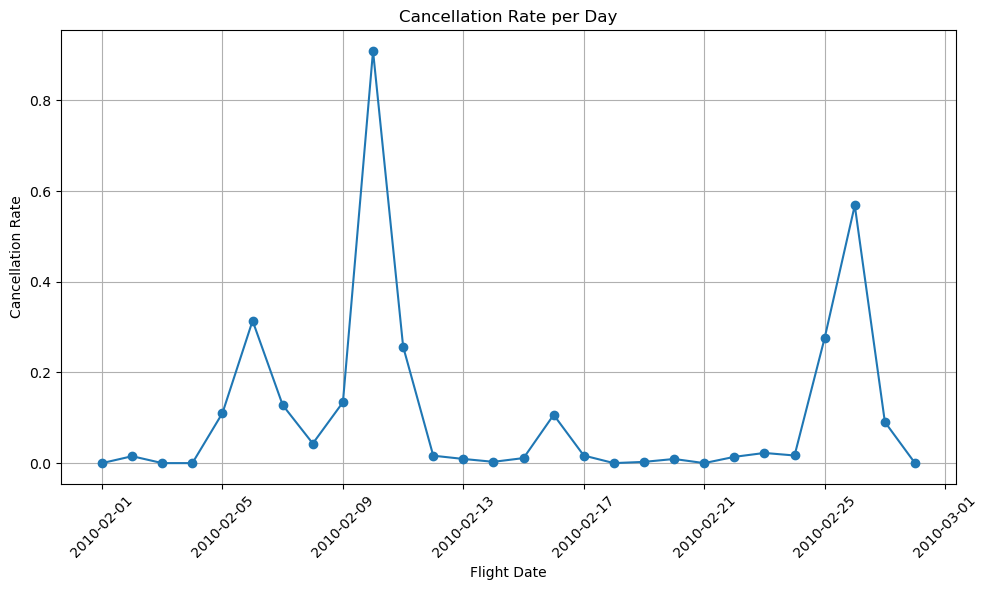

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(cancellation_rate_per_day.index, cancellation_rate_per_day.values, marker='o', linestyle='-')
plt.xlabel('Flight Date')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate per Day')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

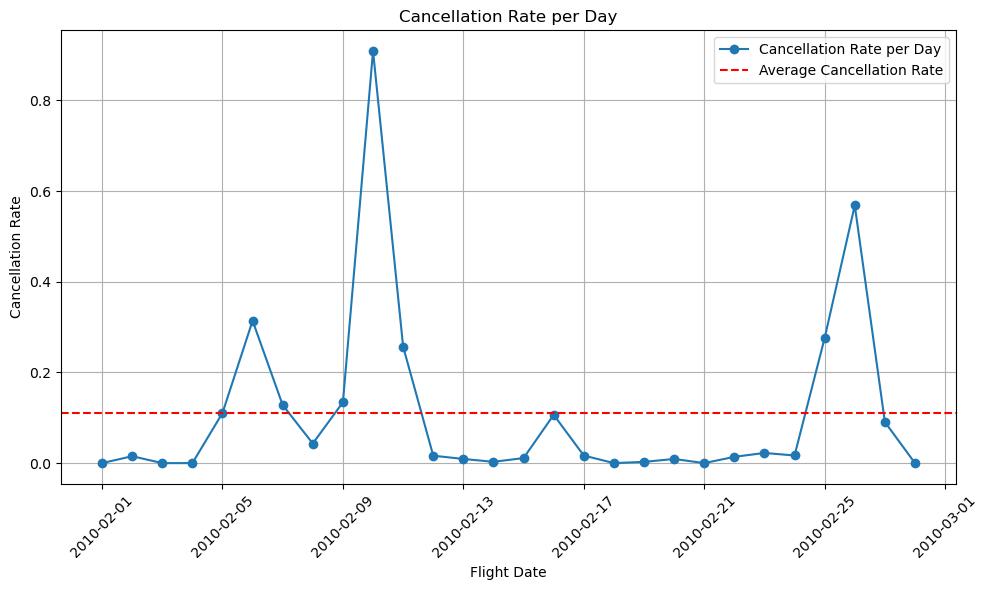

In [9]:
average_cancellation_rate_per_day = cancellation_rate_per_day.mean()

plt.figure(figsize=(10, 6))
plt.plot(cancellation_rate_per_day.index, cancellation_rate_per_day.values, marker='o', linestyle='-', label='Cancellation Rate per Day')
plt.axhline(y=average_cancellation_rate_per_day, color='r', linestyle='--', label='Average Cancellation Rate')
plt.xlabel('Flight Date')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate per Day')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()